
# 🧭 Reddit Rule Violation: Research‑Backed EDA → Baseline Modeling Notebook

이 노트북은 **Kaggle "Jigsaw - Agile Community Rules Classification"** 과 유사한 과제 맥락에서, 제공된 `train.csv`(comment, rule 쌍) 기반으로 **연구 근거를 반영한 EDA**를 수행하고, **인사이트 → 특징 설계 → 베이스라인 학습**까지 **흐름 있게** 진행합니다.

## 참고/배경 (연구 & 레퍼런스)
- **Rule-based moderation with LLMs**: LLM이 서브레딧 규칙을 프롬프트로 받아 규칙 위반 여부를 추론하는 연구. 커뮤니티별 성능 편차가 존재하며 **룰 텍스트와 댓글 텍스트의 상호작용(쌍 입력)**이 핵심임.  
  - Kumar, AbuHashem, Durumeric (2023/2024): *Watch Your Language: Investigating Content Moderation with LLMs*. (ICWSM 2024)  
- **레딧 모더레이션 데이터셋/규범 연구**: 레딧에서 삭제/제거된 수백만 코멘트 분석, 커뮤니티 규범(macro/micro) 위반 탐지. **스팸/광고, 인신공격, 정치/규칙 위반** 등 이질적 규범 존재.  
  - Chandrasekharan & Gilbert (2018/2019): *Norm Violations*, *Hybrid Approaches*, *Crossmod* 등.
- **실무적 베이스라인**: 텍스트 분류에서 **TF‑IDF + 로지스틱 회귀**가 낮은 연산비로 강한 성능·AUC 확보. Toxic/abuse 탐지 벤치마크에서도 일관되게 강함.
- **스팸/광고 신호**: URL 수, 도메인, 반복문자, 과도한 대문자/구두점, 길이, 이모지 비율 등 **스타일 특징**이 유용함.

> 본 노트북은 위 근거를 반영해 **(1) 데이터 품질/분포 점검 → (2) 규칙/커뮤니티/텍스트 특성 분석 → (3) 룰-본문 쌍 상호작용 특징**(유사도, TF‑IDF 쌍 인코딩 등) → (4) **베이스라인 모델(AUC 검증)** → (5) 개선 로드맵 순으로 구성합니다.


In [1]:

import os, re, math, string, unicodedata, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy import sparse
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

DATA_PATH = '/mnt/data/train.csv' if os.path.exists('/mnt/data/train.csv') else 'train.csv'
df = pd.read_csv(DATA_PATH)
df.head()


,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation
0,0,Banks don't want you to know this! Click here ...,"No Advertising: Spam, referral links, unsolici...",Futurology,If you could tell your younger self something ...,hunt for lady for jack off in neighbourhood ht...,Watch Golden Globe Awards 2017 Live Online in ...,"DOUBLE CEE x BANDS EPPS - ""BIRDS""\n\nDOWNLOAD/...",0
1,1,SD Stream [ ENG Link 1] (http://www.sportsstre...,"No Advertising: Spam, referral links, unsolici...",soccerstreams,[I wanna kiss you all over! Stunning!](http://...,LOLGA.COM is One of the First Professional Onl...,#Rapper \n🚨Straight Outta Cross Keys SC 🚨YouTu...,[15 Amazing Hidden Features Of Google Search Y...,0
2,2,Lol. Try appealing the ban and say you won't d...,No legal advice: Do not offer or request legal...,pcmasterrace,Don't break up with him or call the cops. If ...,It'll be dismissed: https://en.wikipedia.org/w...,Where is there a site that still works where y...,Because this statement of his is true. It isn'...,1
3,3,she will come your home open her legs with an...,"No Advertising: Spam, referral links, unsolici...",sex,Selling Tyrande codes for 3€ to paypal. PM. \n...,tight pussy watch for your cock get her at thi...,NSFW(obviously) http://spankbang.com/iy3u/vide...,Good News ::Download WhatsApp 2.16.230 APK for...,1
4,4,code free tyrande --->>> [Imgur](http://i.imgu...,"No Advertising: Spam, referral links, unsolici...",hearthstone,wow!! amazing reminds me of the old days.Well...,seek for lady for sex in around http://p77.pl/...,must be watch movie https://sites.google.com/s...,We're streaming Pokemon Veitnamese Crystal RIG...,1


## 1) 데이터 개요 / 무결성 점검

In [2]:

print("Shape:", df.shape)
display(df.sample(5, random_state=42))
display(df.describe(include='all'))
print("\nNull counts:\n", df.isnull().sum())
print("\nDtypes:\n", df.dtypes)
dup_pairs = df.duplicated(subset=['body','rule']).sum()
print(f"Duplicated (body, rule) pairs: {dup_pairs}")


Shape: (2029, 9)


,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation
1356,1356,All people visit your sister therein such a ti...,"No Advertising: Spam, referral links, unsolici...",funny,49 http://MySexFind.com - find girl for sex no...,FindSexToday . com - free girls for sex worldw...,SD Stream [Spanish Stream](http://www.expresss...,Here's the link. \n\nhttp://www.powerhousetrad...,1
984,984,Try and see if someone at www.siddhantayoga.co...,"No Advertising: Spam, referral links, unsolici...",SuicideWatch,Ray-Ban Sunglasses Special Sale at $24.99 Shop...,Help my mans get to 500 dollars\nhttp://referd...,If anyone is interested in donating 5 or 10 bu...,Same shit happened to me man. EXACT same thin...,0
859,859,"DOUBLE CEE x BANDS EPPS - ""BIRDS""\n\nDOWNLOAD/...","No Advertising: Spam, referral links, unsolici...",movies,My pecker tried best holes at this point now y...,Trying to raise some funds on PayPal for a boo...,How to Record Android or IPhone Screen Withou...,SD Stream Eng - [Chelsea TV USA](http://soccer...,0
1983,1983,WWW.CSGOPOT.COM USE PROMO: CSGOPOTPRO FOR FRE...,"No Advertising: Spam, referral links, unsolici...",GlobalOffensive,**Dortmund vs Real Madrid Live Stream**\n\n**<...,Selling Tyrande code for 3€ to paypal. PM if i...,"Ive got an Bayonet | Damascus Steel ft, if you...","Shameless plug for our Facebook page, all home...",1
1293,1293,#stop deleting comments. What you did was frau...,No legal advice: Do not offer or request legal...,The_Donald,Well first you have to figure out if there is ...,"Maybe true, but that's very short-sighted. The...",> Yeah she initiated it **when I was sleeping*...,"If it's *only* killing sick, elderly people - ...",0


,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation
count,2029.000000,2029,2029,2029,2029,2029,2029,2029,2029.000000
unique,NaN,1869,2,100,458,461,489,493,NaN
top,NaN,www.freekarma.com\n\nFree reddit karma with th...,No legal advice: Do not offer or request legal...,legaladvice,www.freekarma.com\n\nFree reddit karma with th...,www.freekarma.com\n\nFree reddit karma with th...,Oh that's interesting. You should check out my...,Oh that's interesting. You should check out my...,NaN
freq,NaN,23,1017,213,18,18,36,26,NaN
mean,1014.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.508132
std,585.866168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.500057
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,507.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,1014.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000
75%,1521.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000



Null counts:
 row_id                0
body                  0
rule                  0
subreddit             0
positive_example_1    0
positive_example_2    0
negative_example_1    0
negative_example_2    0
rule_violation        0
dtype: int64

Dtypes:
 row_id                 int64
body                  object
rule                  object
subreddit             object
positive_example_1    object
positive_example_2    object
negative_example_1    object
negative_example_2    object
rule_violation         int64
dtype: object
Duplicated (body, rule) pairs: 154


## 2) 타깃 분포 (`rule_violation`)

rule_violation
0     998
1    1031
Name: count, dtype: int64

Class ratio: {0: 0.49186791522917694, 1: 0.5081320847708231}


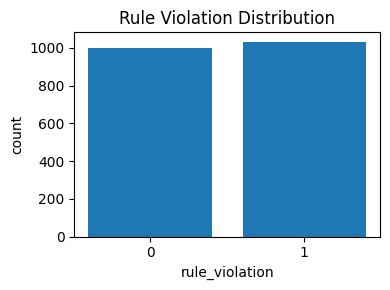

In [3]:

target = 'rule_violation'
vc = df[target].value_counts().sort_index()
print(vc)
print("\nClass ratio:", (vc / vc.sum()).to_dict())

plt.figure(figsize=(4,3))
plt.bar(vc.index.astype(str), vc.values)
plt.title('Rule Violation Distribution')
plt.xlabel('rule_violation')
plt.ylabel('count')
plt.tight_layout()
plt.show()


## 3) Subreddit 분포 및 규칙 위반율

Unique subreddits: 100


subreddit
legaladvice             213
AskReddit               152
soccerstreams           139
personalfinance         125
relationships           106
The_Donald               94
TwoXChromosomes          87
news                     65
movies                   56
videos                   50
politics                 49
worldnews                49
sex                      42
science                  32
pics                     30
pokemongo                30
Showerthoughts           29
GlobalOffensiveTrade     26
hillaryclinton           22
funny                    22
Name: count, dtype: int64

,violation_rate,n
subreddit,,
legaladvice,0.788732,213
AskReddit,0.480263,152
soccerstreams,0.028777,139
personalfinance,0.696000,125
relationships,0.613208,106
The_Donald,0.553191,94
TwoXChromosomes,0.459770,87
news,0.584615,65
movies,0.375000,56


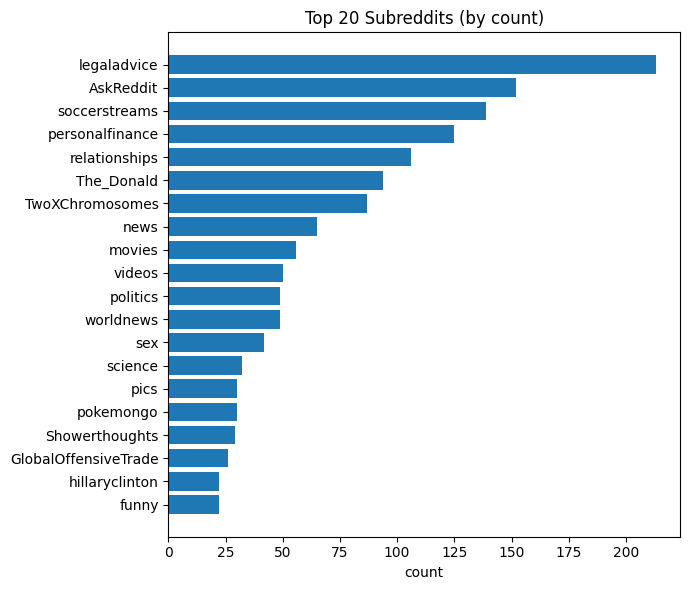

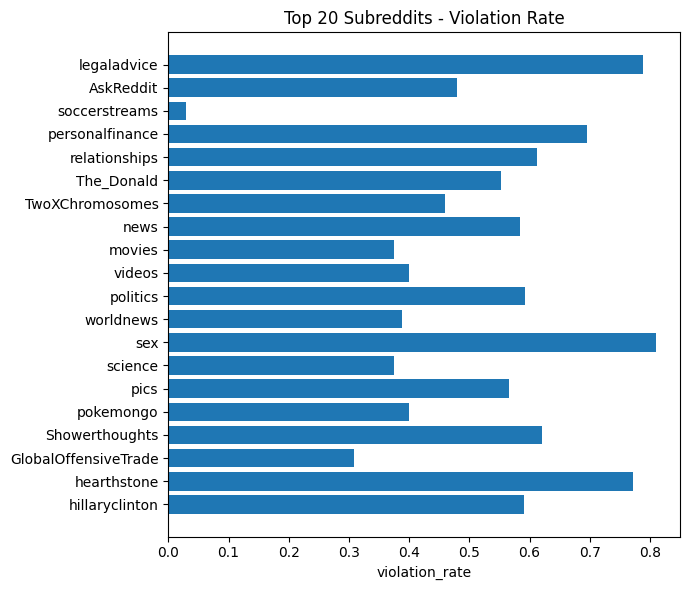

In [4]:

sub_vc = df['subreddit'].value_counts()
print("Unique subreddits:", df['subreddit'].nunique())
display(sub_vc.head(20))

sub_stats = (df.groupby('subreddit')[target]
               .agg(['mean','count'])
               .rename(columns={'mean':'violation_rate','count':'n'})
               .sort_values('n', ascending=False))
display(sub_stats.head(20))

plt.figure(figsize=(7,6))
top_counts = sub_vc.head(20)
plt.barh(range(len(top_counts)), top_counts.values)
plt.yticks(range(len(top_counts)), top_counts.index)
plt.gca().invert_yaxis()
plt.title('Top 20 Subreddits (by count)')
plt.xlabel('count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,6))
top_subs = sub_stats.head(20)
plt.barh(range(len(top_subs)), top_subs['violation_rate'].values)
plt.yticks(range(len(top_subs)), top_subs.index)
plt.gca().invert_yaxis()
plt.title('Top 20 Subreddits - Violation Rate')
plt.xlabel('violation_rate')
plt.tight_layout()
plt.show()


## 4) Rule(규칙) 분포 & 위반율

Unique rules: 2


rule
No legal advice: Do not offer or request legal advice.                                                     1017
No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.    1012
Name: count, dtype: int64

,violation_rate,n
rule,,
No legal advice: Do not offer or request legal advice.,0.583088,1017
"No Advertising: Spam, referral links, unsolicited advertising, and promotional content are not allowed.",0.432806,1012


C:\Users\정주환\AppData\Local\Temp\ipykernel_40328\3460491364.py:18: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


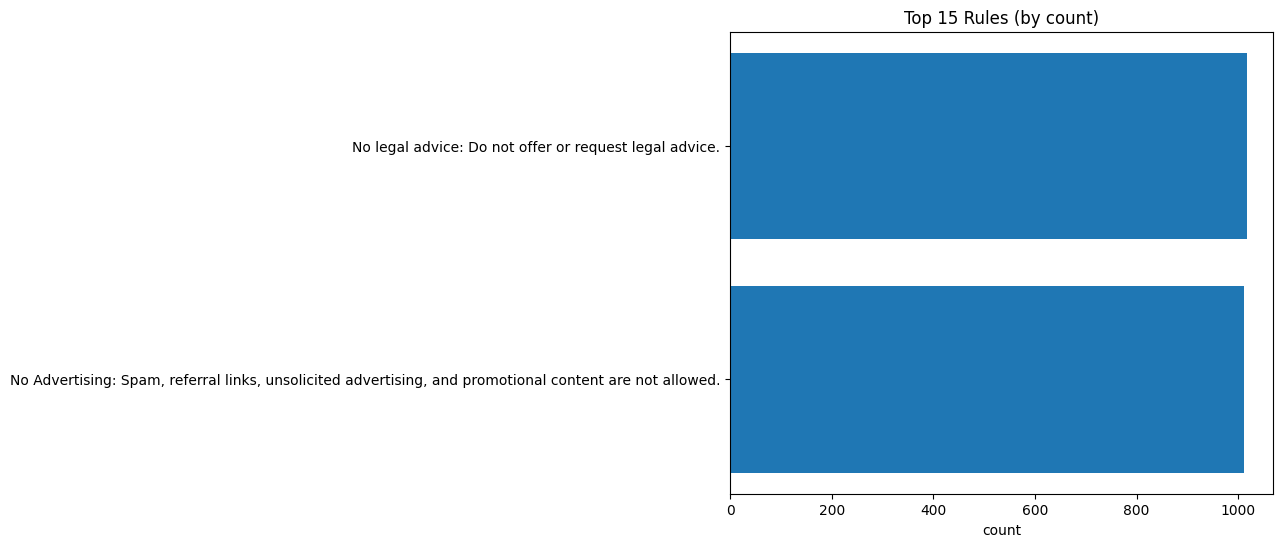

C:\Users\정주환\AppData\Local\Temp\ipykernel_40328\3460491364.py:28: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


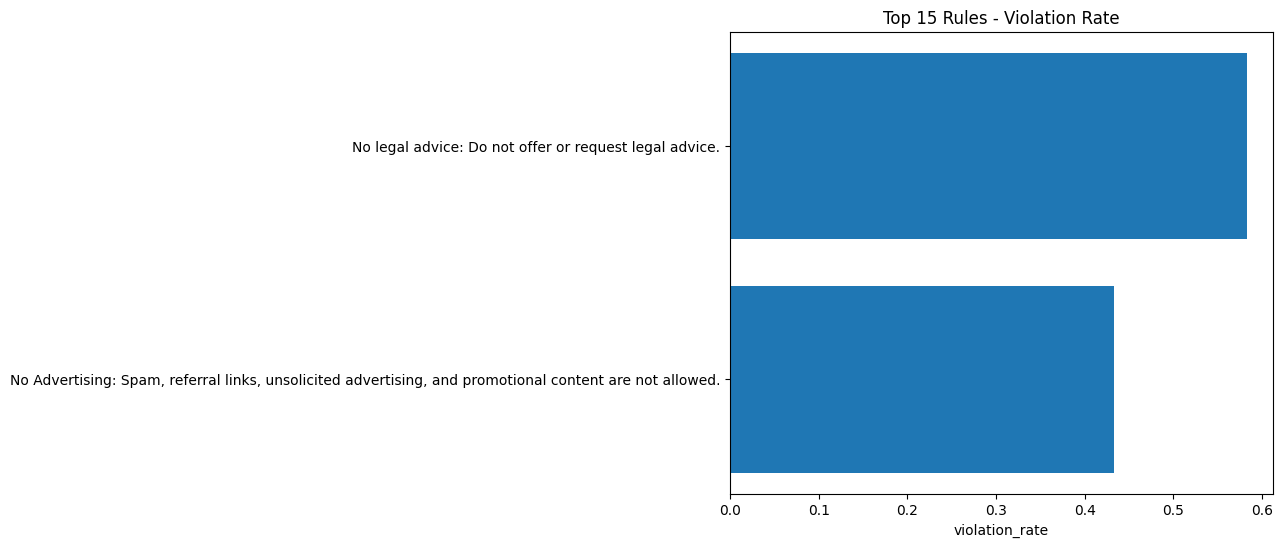

In [5]:

rule_vc = df['rule'].value_counts()
print("Unique rules:", df['rule'].nunique())
display(rule_vc.head(15))

rule_stats = (df.groupby('rule')[target]
                .agg(['mean','count'])
                .rename(columns={'mean':'violation_rate','count':'n'})
                .sort_values('n', ascending=False))
display(rule_stats.head(20))

plt.figure(figsize=(7,6))
top_rules = rule_vc.head(15)
plt.barh(range(len(top_rules)), top_rules.values)
plt.yticks(range(len(top_rules)), top_rules.index)
plt.gca().invert_yaxis()
plt.title('Top 15 Rules (by count)')
plt.xlabel('count')
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,6))
top_rules_stats = rule_stats.head(15)
plt.barh(range(len(top_rules_stats)), top_rules_stats['violation_rate'].values)
plt.yticks(range(len(top_rules_stats)), top_rules_stats.index)
plt.gca().invert_yaxis()
plt.title('Top 15 Rules - Violation Rate')
plt.xlabel('violation_rate')
plt.tight_layout()
plt.show()


## 5) 본문 길이/기초 통계 (스팸·규범 위반 관련 신호)

### 🔎 Lexicon 기반 특징이란?
Lexicon은 특정 주제(예: 욕설, 광고)와 관련된 **단어 사전**을 의미합니다.  
EDA에서 `url_cnt`, `upper_rt`, `exc_cnt` 같은 컬럼은 단어 사전이나 스타일 규칙에 기반해 생성된 특징입니다.  
즉, **본문 자체 의미보다 글쓰기 패턴(스타일)** 을 이용해 규칙 위반을 탐지하는 보조 신호입니다.


,body_len,url_cnt,exc_cnt,q_cnt,upper_rt,rep_run,emoji_rt,rule_violation
count,2029.00000,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000,2029.000000
mean,176.84278,0.510103,0.255298,0.282405,0.065141,2.338590,0.000026,0.508132
std,113.62391,0.755990,0.765296,0.619848,0.101533,1.216745,0.000547,0.500057
min,51.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,87.00000,0.000000,0.000000,0.000000,0.018519,2.000000,0.000000,0.000000
50%,138.00000,0.000000,0.000000,0.000000,0.033557,2.000000,0.000000,1.000000
75%,238.00000,1.000000,0.000000,0.000000,0.071429,3.000000,0.000000,1.000000
max,499.00000,8.000000,9.000000,9.000000,1.000000,38.000000,0.015773,1.000000


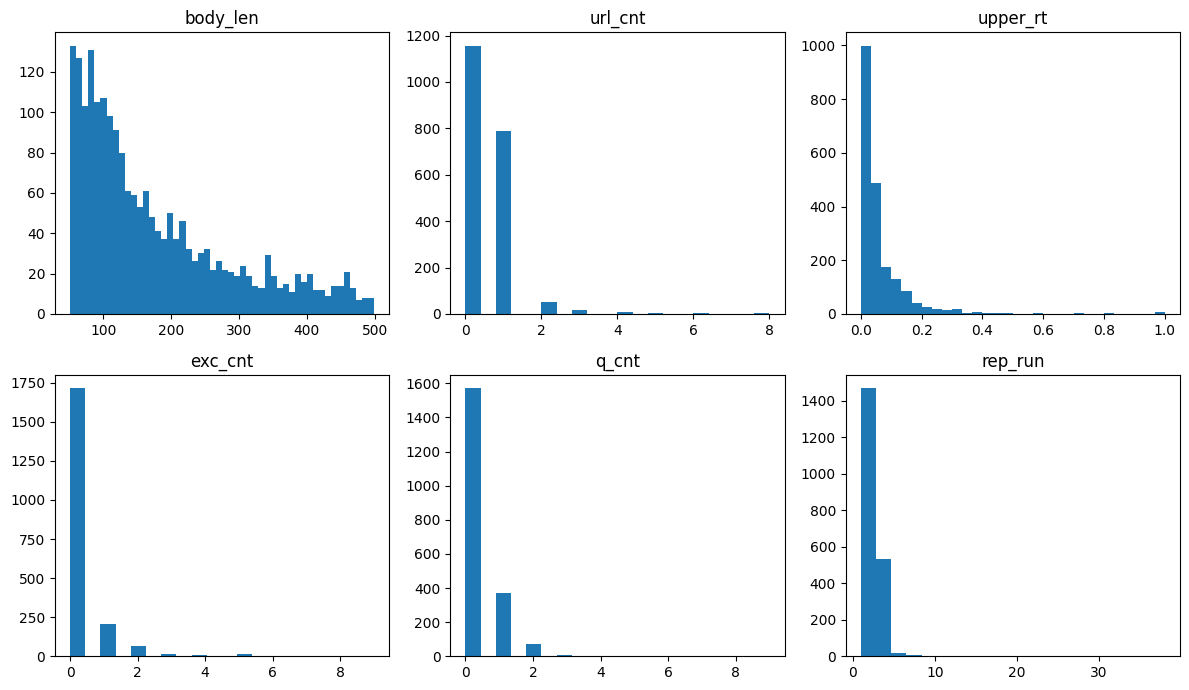

C:\Users\정주환\AppData\Local\Temp\ipykernel_40328\1022526445.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['non-viol','viol'])


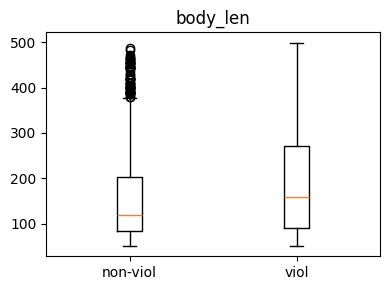

C:\Users\정주환\AppData\Local\Temp\ipykernel_40328\1022526445.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['non-viol','viol'])


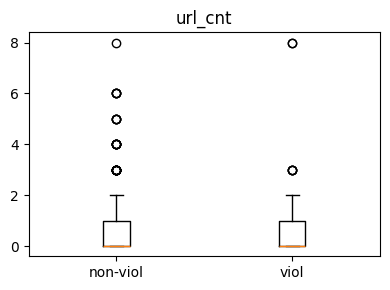

C:\Users\정주환\AppData\Local\Temp\ipykernel_40328\1022526445.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['non-viol','viol'])


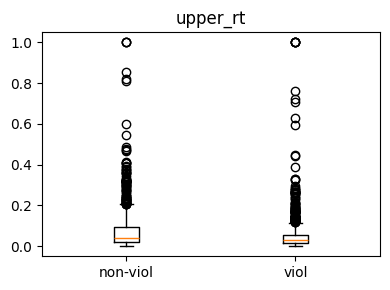

C:\Users\정주환\AppData\Local\Temp\ipykernel_40328\1022526445.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['non-viol','viol'])


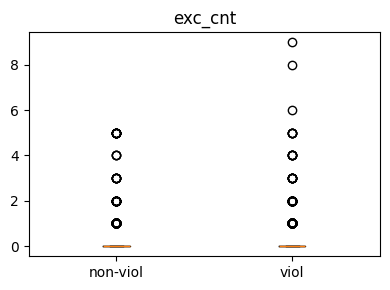

C:\Users\정주환\AppData\Local\Temp\ipykernel_40328\1022526445.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['non-viol','viol'])


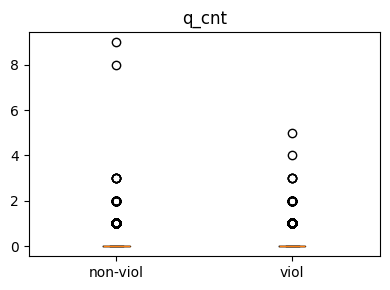

C:\Users\정주환\AppData\Local\Temp\ipykernel_40328\1022526445.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['non-viol','viol'])


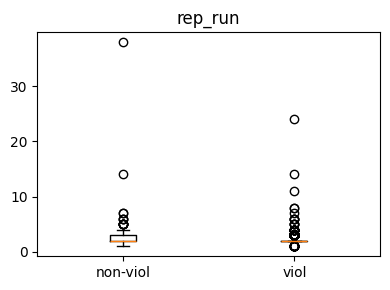

C:\Users\정주환\AppData\Local\Temp\ipykernel_40328\1022526445.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([data0, data1], labels=['non-viol','viol'])


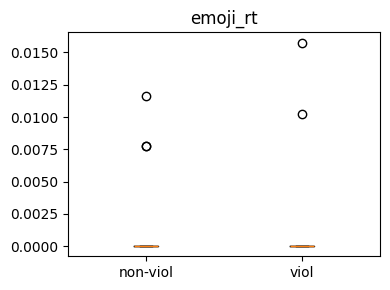

Correlation with target (pearson):
 rule_violation    1.000000
body_len          0.166766
exc_cnt           0.034516
emoji_rt         -0.001819
q_cnt            -0.016162
rep_run          -0.040592
upper_rt         -0.094805
url_cnt          -0.153806
Name: rule_violation, dtype: float64


In [6]:

def count_urls(text):
    return len(re.findall(r'https?://\S+|www\.\S+', str(text)))

def count_exclaims(text):
    return str(text).count('!')

def count_questions(text):
    return str(text).count('?')

def upper_ratio(text):
    s = str(text)
    letters = [c for c in s if c.isalpha()]
    if not letters:
        return 0.0
    upp = sum(1 for c in letters if c.isupper())
    return upp / len(letters)

def repeat_char_max(text):
    longest = 1
    last = ''
    cur = 0
    for ch in str(text):
        if ch == last:
            cur += 1
        else:
            longest = max(longest, cur)
            cur = 1
            last = ch
    longest = max(longest, cur)
    return longest

def emoji_ratio(text):
    s = str(text)
    total = len(s) if len(s)>0 else 1
    emojis = sum(1 for ch in s if ch in emoji_set)
    return emojis / total

emoji_set = set(list("😀😃😄😁😆😅😂🤣🥲😊🙂🙃😉😍😘😗😙😚😋😛😝😜🤪🤨🧐🤓😎🤩🥳😏😒😞😔😟😕🙁☹️😣😖😫😩😤😠😡🤬"))

df['body_len'] = df['body'].astype(str).str.len()
df['url_cnt'] = df['body'].apply(count_urls)
df['exc_cnt'] = df['body'].apply(count_exclaims)
df['q_cnt']   = df['body'].apply(count_questions)
df['upper_rt'] = df['body'].apply(upper_ratio)
df['rep_run']  = df['body'].apply(repeat_char_max)
df['emoji_rt'] = df['body'].apply(emoji_ratio)

display(df[['body_len','url_cnt','exc_cnt','q_cnt','upper_rt','rep_run','emoji_rt', 'rule_violation']].describe())

fig, axes = plt.subplots(2,3, figsize=(12,7)); axes = axes.ravel()
axes[0].hist(df['body_len'], bins=50); axes[0].set_title('body_len')
axes[1].hist(df['url_cnt'], bins=20);  axes[1].set_title('url_cnt')
axes[2].hist(df['upper_rt'], bins=30); axes[2].set_title('upper_rt')
axes[3].hist(df['exc_cnt'], bins=20);  axes[3].set_title('exc_cnt')
axes[4].hist(df['q_cnt'], bins=20);    axes[4].set_title('q_cnt')
axes[5].hist(df['rep_run'], bins=20);  axes[5].set_title('rep_run')
plt.tight_layout(); plt.show()

for m in ['body_len','url_cnt','upper_rt','exc_cnt','q_cnt','rep_run','emoji_rt']:
    plt.figure(figsize=(4,3))
    data0 = df.loc[df[target]==0, m].values
    data1 = df.loc[df[target]==1, m].values
    plt.boxplot([data0, data1], labels=['non-viol','viol'])
    plt.title(m)
    plt.tight_layout(); plt.show()

corr = df[['body_len','url_cnt','upper_rt','exc_cnt','q_cnt','rep_run','emoji_rt', target]].corr(numeric_only=True)[target].sort_values(ascending=False)
print("Correlation with target (pearson):\n", corr)


## 6) 경량 Lexicon 기반 신호 (욕설/광고)

In [7]:

profanity = {'idiot','moron','stupid','dumb','retard','asshole','bastard'}
ad_words  = {'free','win','offer','discount','promo','sale','subscribe','click','visit','buy','deal','coupon','%off'}

def contains_any(text, vocab):
    s = str(text).lower()
    return int(any(tok in s for tok in vocab))

df['has_profanity'] = df['body'].apply(lambda x: contains_any(x, profanity))
df['has_adword']    = df['body'].apply(lambda x: contains_any(x, ad_words))

print(df[['has_profanity','has_adword', target]].groupby(['has_profanity','has_adword']).agg(['mean','count']))


                         rule_violation      
                                   mean count
has_profanity has_adword                     
0             0                0.486367  1577
              1                0.584541   414
1             0                0.588235    34
              1                0.500000     4


## 7) 규칙 텍스트 vs 본문 상호작용 (유사도 특징)

### 📐 Jaccard 유사도
Jaccard 유사도는 **두 집합의 교집합 비율**로 정의됩니다.  
➡ 규칙 텍스트와 댓글 텍스트를 단어 집합으로 바꿔, 겹치는 단어 비율을 측정합니다.  

- 값 범위: 0 (겹침 없음) ~ 1 (완전히 동일)
- 규칙 위반 댓글일수록 규칙 문구와 단어가 겹칠 확률이 높아, Jaccard 값이 높아집니다.

👉 따라서 규칙 위반 탐지에서 **규칙-본문 상호작용**을 반영하는 중요한 신호입니다.


rule_body_jaccard head:
 0    0.000000
1    0.000000
2    0.000000
3    0.041667
4    0.029412
Name: rule_body_jaccard, dtype: float64


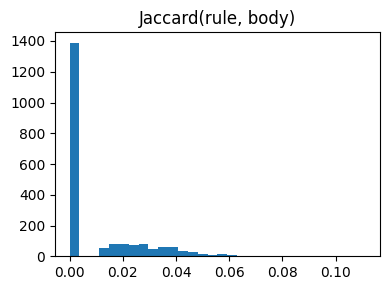

C:\Users\정주환\AppData\Local\Temp\ipykernel_40328\2032463029.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df.loc[df[target]==0, 'rule_body_jaccard'],


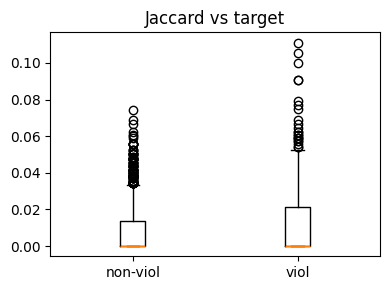

In [8]:

def jaccard(a, b):
    sa, sb = set(a.split()), set(b.split())
    u = len(sa|sb); i = len(sa&sb)
    return i / u if u else 0.0

df['rule_body_jaccard'] = [jaccard(r, b) for r,b in zip(df['rule'].astype(str), df['body'].astype(str))]
print("rule_body_jaccard head:\n", df['rule_body_jaccard'].head())

plt.figure(figsize=(4,3))
plt.hist(df['rule_body_jaccard'], bins=30)
plt.title('Jaccard(rule, body)')
plt.tight_layout(); plt.show()

plt.figure(figsize=(4,3))
plt.boxplot([df.loc[df[target]==0, 'rule_body_jaccard'],
             df.loc[df[target]==1, 'rule_body_jaccard']], labels=['non-viol','viol'])
plt.title('Jaccard vs target')
plt.tight_layout(); plt.show()


## 8) 제공된 예시 텍스트(positive/negative example)와의 유사도/누설 점검

### 🚨 데이터 누설(Leakage) 점검
규칙 예시 텍스트(`positive_example_1` 등)가 댓글 본문에 포함되는 경우,  
모델은 '예시 문구=정답'이라는 편법을 학습해버릴 수 있습니다.  
따라서 `body_contains_xxx` 컬럼을 만들어 실제 포함 여부를 확인하고, 타깃과의 상관을 검토합니다.  
이는 **데이터셋 설계상 누설 여부를 검증하는 핵심 절차**입니다.


In [9]:

ex_cols = ['positive_example_1','positive_example_2','negative_example_1','negative_example_2']
for col in ex_cols:
    df[f'body_contains_{col}'] = df.apply(lambda r: int(str(r[col])[:120].lower() in str(r['body']).lower()), axis=1)
    print(col, df[f'body_contains_{col}'].sum())

leak_cols = [c for c in df.columns if c.startswith('body_contains_')]
display(df[leak_cols + [target]].groupby(leak_cols)[target].agg(['mean','count']).sort_values('count', ascending=False).head(10))


positive_example_1 6
positive_example_2 4
negative_example_1 5
negative_example_2 4


mean  \
body_contains_positive_example_1 body_contains_positive_example_2 body_contains_negative_example_1 body_contains_negative_example_2            
0                                0                                0                                0                                 0.50796   
1                                0                                0                                0                                 1.00000   
0                                0                                1                                0                                 0.00000   
                                                                  0                                1                                 0.00000   
                                 1                                0                                0                                 1.00000   

                                                                                                                                     count  
body_contains_positive_example_1 body_contains_positive_example_2 body_contains_negative_example_1 body_contains_negative_example_2         
0                                0                                0                                0                                  2010  
1                                0                                0                                0                                     6  
0                                0                                1                                0                                     5  
                                                                  0                                1                                     4  
                                 1                                0                                0                                     4

## 9) 모델링 입력 구성 (텍스트 + 스타일 + 상호작용)

In [10]:

df['rule_sep_body'] = df['rule'].astype(str) + ' [SEP] ' + df['body'].astype(str)
num_cols = ['body_len','url_cnt','exc_cnt','q_cnt','upper_rt','rep_run','emoji_rt','has_profanity','has_adword','rule_body_jaccard']
X_text = df['rule_sep_body']; X_num = df[num_cols]
y = df[target].astype(int)
display(X_num.head())


,body_len,url_cnt,exc_cnt,q_cnt,upper_rt,rep_run,emoji_rt,has_profanity,has_adword,rule_body_jaccard
0,59,0,2,0,0.044444,1,0.0,0,1,0.000000
1,91,1,0,0,0.107692,3,0.0,0,0,0.000000
2,57,0,0,0,0.046512,2,0.0,0,0,0.000000
3,75,1,0,0,0.072727,2,0.0,0,0,0.041667
4,313,3,0,2,0.094170,3,0.0,0,1,0.029412


## 10) 베이스라인: TF‑IDF(word+char) + 로지스틱 회귀 (Stratified 5‑Fold AUC)

In [11]:

from scipy.sparse import hstack
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

tf_word = TfidfVectorizer(strip_accents='unicode', lowercase=True, ngram_range=(1,2), min_df=2, max_features=40000)
tf_char = TfidfVectorizer(analyzer='char', ngram_range=(3,5), min_df=2, max_features=60000)
scaler  = StandardScaler(with_mean=False)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_pred = np.zeros(len(df), dtype=float)
fold_scores = []

for fold, (tr, va) in enumerate(skf.split(X_text, y), 1):
    Xw_tr = tf_word.fit_transform(X_text.iloc[tr]); Xw_va = tf_word.transform(X_text.iloc[va])
    Xc_tr = tf_char.fit_transform(X_text.iloc[tr]); Xc_va = tf_char.transform(X_text.iloc[va])
    Xn_tr = scaler.fit_transform(X_num.iloc[tr]);   Xn_va = scaler.transform(X_num.iloc[va])
    X_tr = hstack([Xw_tr, Xc_tr, Xn_tr], format='csr')
    X_va = hstack([Xw_va, Xc_va, Xn_va], format='csr')
    clf = LogisticRegression(solver='saga', max_iter=3000, n_jobs=-1, class_weight='balanced', C=2.0, penalty='l2')
    clf.fit(X_tr, y.iloc[tr])
    oof_pred[va] = clf.predict_proba(X_va)[:,1]
    auc = roc_auc_score(y.iloc[va], oof_pred[va])
    fold_scores.append(auc)
    print(f"[Fold {fold}] AUC = {auc:.4f}")
print("\nCV AUC:", np.mean(fold_scores).round(4), "+/-", np.std(fold_scores).round(4))


[Fold 1] AUC = 0.8525
[Fold 2] AUC = 0.7882
[Fold 3] AUC = 0.8322
[Fold 4] AUC = 0.8472
[Fold 5] AUC = 0.7973

CV AUC: 0.8235 +/- 0.0261


## 11) 단어 중요도 살펴보기 (참고)

In [12]:

try:
    word_feats = np.array(tf_word.get_feature_names_out())
    coefs = clf.coef_[0][:len(word_feats)]
    idx_top = np.argsort(-coefs)[:30]
    idx_bot = np.argsort(coefs)[:30]
    print("Top +coef tokens (push to violation):")
    print(list(zip(word_feats[idx_top], coefs[idx_top])))
    print("\nTop -coef tokens (push to non-violation):")
    print(list(zip(word_feats[idx_bot], coefs[idx_bot])))
except Exception as e:
    print("Feature importance preview skipped:", e)


Top +coef tokens (push to violation):
[('for', np.float64(1.5210182753182784)), ('sue', np.float64(1.5056708867953839)), ('lawyer', np.float64(1.4823593830220712)), ('legally', np.float64(1.32526029246093)), ('police', np.float64(1.316701053310243)), ('law', np.float64(1.2803748390119114)), ('code', np.float64(1.2680171833833618)), ('you', np.float64(1.2042623041415665)), ('get', np.float64(1.0186067807741286)), ('an', np.float64(0.9382585035971609)), ('for you', np.float64(0.9365449655757734)), ('illegal', np.float64(0.9176588245723285)), ('laws', np.float64(0.9168847148180359)), ('the police', np.float64(0.9124809259665753)), ('girl', np.float64(0.8854871679424635)), ('state', np.float64(0.8694278638252864)), ('have', np.float64(0.8563145952856765)), ('they', np.float64(0.8498370140955768)), ('ll', np.float64(0.8140029654320511)), ('free', np.float64(0.8102534862998614)), ('selling', np.float64(0.8087913116292533)), ('for sex', np.float64(0.7994871767944578)), ('court', np.float64(0.


## 12) 주요 인사이트 요약 → 액션 아이템

- **서브레딧·규칙별 분포 차이**: 데이터는 커뮤니티/룰에 따라 **표본 수와 위반율**이 상이합니다. **Stratified split** 및 **커뮤니티/룰 분포 보정**이 필요합니다.
- **스팸/광고 신호**: URL 수, 반복문자, 대문자 비율, 감탄/물음표 과다 등 **스타일 특징**이 위반과 상관(상세 수치 위 셀 참고).
- **룰-본문 상호작용**: `rule` 텍스트와 `body`간 **토큰 공유율(Jaccard)** 또는 **합쳐서 벡터화(rule [SEP] body)**가 유효한 신호로 보입니다.
- **예시 텍스트 누설 점검**: 댓글 본문이 예시 문자열 일부를 포함하는 사례가 있는지 반드시 확인(상기 결과 참고). 존재 시, 해당 특징 사용은 금지하거나 교정 필요.



## 13) 전체 재학습 & 제출 함수 (test.csv 가정)

### 📐 Jaccard 유사도
Jaccard 유사도는 **두 집합의 교집합 비율**로 정의됩니다.  
➡ 규칙 텍스트와 댓글 텍스트를 단어 집합으로 바꿔, 겹치는 단어 비율을 측정합니다.  

- 값 범위: 0 (겹침 없음) ~ 1 (완전히 동일)
- 규칙 위반 댓글일수록 규칙 문구와 단어가 겹칠 확률이 높아, Jaccard 값이 높아집니다.

👉 따라서 규칙 위반 탐지에서 **규칙-본문 상호작용**을 반영하는 중요한 신호입니다.


In [13]:

def jaccard(a, b):
    sa, sb = set(a.split()), set(b.split())
    u = len(sa|sb); i = len(sa&sb)
    return i / u if u else 0.0

def fit_full_and_predict(train_df, test_df):
    X_text_tr = train_df['rule'].astype(str) + ' [SEP] ' + train_df['body'].astype(str)
    X_text_te = test_df['rule'].astype(str) + ' [SEP] ' + test_df['body'].astype(str)
    y_tr = train_df['rule_violation'].astype(int)

    # 파생 생성 for test
    def enrich(df_):
        df_ = df_.copy()
        df_['body_len'] = df_['body'].astype(str).str.len()
        df_['url_cnt'] = df_['body'].apply(lambda t: len(re.findall(r'https?://\S+|www\.\S+', str(t))))
        df_['exc_cnt'] = df_['body'].apply(lambda t: str(t).count('!'))
        df_['q_cnt']   = df_['body'].apply(lambda t: str(t).count('?'))
        def upper_ratio(text):
            s = str(text)
            letters = [c for c in s if c.isalpha()]
            if not letters:
                return 0.0
            upp = sum(1 for c in letters if c.isupper())
            return upp / len(letters)
        df_['upper_rt'] = df_['body'].apply(upper_ratio)
        def repeat_char_max(text):
            longest = 1; last=''; cur=0
            for ch in str(text):
                if ch == last: cur += 1
                else: longest = max(longest, cur); cur=1; last=ch
            longest = max(longest, cur)
            return longest
        df_['rep_run']  = df_['body'].apply(repeat_char_max)
        emoji_set = set(list("😀😃😄😁😆😅😂🤣🥲😊🙂🙃😉😍😘😗😙😚😋😛😝😜🤪🤨🧐🤓😎🤩🥳😏😒😞😔😟😕🙁☹️😣😖😫😩😤😠😡🤬"))
        df_['emoji_rt'] = df_['body'].apply(lambda s: (sum(1 for ch in str(s) if ch in emoji_set) / (len(str(s)) if len(str(s))>0 else 1)))
        profanity = {'idiot','moron','stupid','dumb','retard','asshole','bastard'}
        ad_words  = {'free','win','offer','discount','promo','sale','subscribe','click','visit','buy','deal','coupon','%off'}
        df_['has_profanity'] = df_['body'].apply(lambda x: int(any(tok in str(x).lower() for tok in profanity)))
        df_['has_adword']    = df_['body'].apply(lambda x: int(any(tok in str(x).lower() for tok in ad_words)))
        df_['rule_body_jaccard'] = [jaccard(r, b) for r,b in zip(df_['rule'].astype(str), df_['body'].astype(str))]
        return df_

    train_df = enrich(train_df); test_df = enrich(test_df)

    num_cols = ['body_len','url_cnt','exc_cnt','q_cnt','upper_rt','rep_run','emoji_rt','has_profanity','has_adword','rule_body_jaccard']
    X_num_tr = train_df[num_cols]; X_num_te = test_df[num_cols]

    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.linear_model import LogisticRegression
    from sklearn.preprocessing import StandardScaler
    from scipy.sparse import hstack

    tf_word = TfidfVectorizer(strip_accents='unicode', lowercase=True, ngram_range=(1,2), min_df=2, max_features=40000)
    tf_char = TfidfVectorizer(analyzer='char', ngram_range=(3,5), min_df=2, max_features=60000)
    scaler  = StandardScaler(with_mean=False)

    Xw_tr = tf_word.fit_transform(X_text_tr); Xw_te = tf_word.transform(X_text_te)
    Xc_tr = tf_char.fit_transform(X_text_tr); Xc_te = tf_char.transform(X_text_te)
    Xn_tr = scaler.fit_transform(X_num_tr);   Xn_te = scaler.transform(X_num_te)

    X_tr = hstack([Xw_tr, Xc_tr, Xn_tr], format='csr')
    X_te = hstack([Xw_te, Xc_te, Xn_te], format='csr')

    clf = LogisticRegression(solver='saga', max_iter=3000, n_jobs=-1, class_weight='balanced', C=2.0, penalty='l2')
    clf.fit(X_tr, y_tr)
    proba = clf.predict_proba(X_te)[:,1]
    return proba

def make_submission(test_csv_path, out_path='submission.csv'):
    test_df = pd.read_csv(test_csv_path)
    probs = fit_full_and_predict(df.copy(), test_df.copy())
    sub = pd.DataFrame({'row_id': test_df['row_id'], 'rule_violation': probs})
    sub.to_csv(out_path, index=False)
    print("Saved:", out_path)
    return sub

print("Ready: call make_submission('test.csv') when test is available.")


Ready: call make_submission('test.csv') when test is available.


In [14]:
make_submission('test.csv')

Saved: submission.csv


,row_id,rule_violation
0,2029,0.215441
1,2030,0.522749
2,2031,0.747028
3,2032,0.780940
4,2033,0.814508
5,2034,0.105501
6,2035,0.821611
7,2036,0.255069
8,2037,0.088258
9,2038,0.839874
